In [1]:
%pip install opencv-python
%pip install tensorflow
%pip install keras
%pip install mediapipe
%pip install torchvision
%pip install yt_dlp
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Dataset collection

In [2]:
import os
import cv2
import yt_dlp

# ---------- CONFIG ----------
SHOT_VIDEOS = {
    "coverdrive": [
        "https://www.youtube.com/watch?v=5OGkvFUl3G8",
        "https://www.youtube.com/watch?v=Z2TMN715wmY"
    ],
    "pull": [
        "https://www.youtube.com/watch?v=ePmiyHWxMDk"
    ],
    "cut": [
        "https://www.youtube.com/watch?v=woRWcqgxnkM"
    ],
    "sweep": [
        "https://www.youtube.com/watch?v=3Lzsk8SpNns"
    ],
    "lofteddrive": [
        "https://www.youtube.com/watch?v=g1yfMljc8Dk"
    ],
    "straighdrive": [
        "https://www.youtube.com/watch?v=3UTL5Hj4i6U"
    ]
}

DOWNLOAD_DIR = "downloads"
OUTPUT_DIR = r"D:\Main\data"
CLIP_LENGTH = 3  # seconds
# ----------------------------


def download_videos(urls, download_dir, shot_name):
    """Download YouTube videos for a specific shot type (video only)."""
    os.makedirs(download_dir, exist_ok=True)
    ydl_opts = {
        "format": "bestvideo[ext=mp4]/bestvideo",  # only video, prefer mp4
        "outtmpl": os.path.join(download_dir, f"{shot_name}_%(title)s.%(ext)s"),
        "postprocessors": []  # no ffmpeg merging (no audio)
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download(urls)


def split_video(video_path, output_dir, shot_name, clip_length=3):
    """Split a video into multiple clips of given length (in seconds)."""
    shot_dir = os.path.join(output_dir, shot_name)
    os.makedirs(shot_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    clip_frames = fps * clip_length
    clip_num = 1

    while True:
        frames = []
        for _ in range(clip_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)

        if frames:
            clip_path = os.path.join(shot_dir, f"{shot_name}_clip_{clip_num}.avi")
            h, w, _ = frames[0].shape
            out = cv2.VideoWriter(
                clip_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (w, h)
            )
            for f in frames:
                out.write(f)
            out.release()
            print(f"Saved: {clip_path}")
            clip_num += 1
        else:
            break
    cap.release()


if __name__ == "__main__":
    # Step 1: Download cricket videos by shot type
    for shot_name, urls in SHOT_VIDEOS.items():
        print(f"\nDownloading {shot_name} videos...")
        download_videos(urls, DOWNLOAD_DIR, shot_name)

    # Step 2: Split them into clips
    for file in os.listdir(DOWNLOAD_DIR):
        if file.endswith((".mp4", ".mkv", ".webm", ".avi")):
            video_path = os.path.join(DOWNLOAD_DIR, file)
            shot_name = file.split("_")[0]  # get class from filename prefix
            split_video(video_path, OUTPUT_DIR, shot_name, CLIP_LENGTH)



[youtube] Extracting URL: https://www.youtube.com/watch?v=5OGkvFUl3G8
[youtube] 5OGkvFUl3G8: Downloading webpage
[youtube] 5OGkvFUl3G8: Downloading tv simply player API JSON
[youtube] 5OGkvFUl3G8: Downloading tv client config
[youtube] 5OGkvFUl3G8: Downloading tv player API JSON
[info] 5OGkvFUl3G8: Downloading 1 format(s): 398
[download] Sleeping 2.00 seconds as required by the site...
[download] Destination: downloads\coverdrive_Who Played It Best？ ｜ Best Cover Drives of the World Cup ｜ Part 1 ｜ ICC Cricket World Cup 2019.mp4
[download] 100% of   18.47MiB in 00:00:03 at 5.03MiB/s     
[youtube] Extracting URL: https://www.youtube.com/watch?v=Z2TMN715wmY
[youtube] Z2TMN715wmY: Downloading webpage
[youtube] Z2TMN715wmY: Downloading tv simply player API JSON
[youtube] Z2TMN715wmY: Downloading tv client config
[youtube] Z2TMN715wmY: Downloading tv player API JSON
[info] Z2TMN715wmY: Downloading 1 format(s): 399
[download] Sleeping 2.00 seconds as required by the site...
[download] Destin

Feature Extraction
#This script extracts the keypoints from the frames and saves it in a .csv file

In [3]:
import cv2
import mediapipe as mp
import os
import numpy as np
import csv

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

root_dirs = ["coverdrive", "cut", "lofteddrive", "pull", "straighdrive", "sweep"]
base_path = r"D:\pro\data"  # Change if your folders are elsewhere

# CSV file to save features: each row is a frame keypoints + label + video filename
with open('pose_features.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write header (x, y, z for each landmark * number of landmarks + label + video filename)
    header = []
    for i in range(33):  # Pose has 33 landmarks
        header += [f'x{i}', f'y{i}', f'z{i}']
    header += ['label', 'video']
    csv_writer.writerow(header)
    
    for label in root_dirs:
        folder_path = os.path.join(base_path, label)
        for video_file in os.listdir(folder_path):
            if video_file.endswith('.avi'):
                video_path = os.path.join(folder_path, video_file)
                cap = cv2.VideoCapture(video_path)
                
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    
                    # Convert frame color from BGR to RGB for mediapipe
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    
                    # Process frame to get pose landmarks
                    results = pose.process(frame_rgb)
                    
                    if results.pose_landmarks:
                        landmarks = results.pose_landmarks.landmark
                        row = []
                        for lm in landmarks:
                            row.extend([lm.x, lm.y, lm.z])
                        
                        row.append(label)
                        row.append(video_file)
                        
                        csv_writer.writerow(row)
                cap.release()

pose.close()
print("Pose keypoints extraction completed and saved to pose_features.csv")


c:\Users\Hemnath\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Pose keypoints extraction completed and saved to pose_features.csv


In [4]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install tensorflow


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Model training and saving


Starting improved model training...
Original samples: 405
Total samples after augmentation: 810


c:\Users\Hemnath\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 28, 128)        │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 14, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,846 (1.88 MB)

 Trainable params: 491,334 (1.87 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.2338 - loss: 2.4163 - val_accuracy: 0.1420 - val_loss: 1.7353 - learning_rate: 0.0010
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3782 - loss: 1.8430 - val_accuracy: 0.1420 - val_loss: 1.7852 - learning_rate: 0.0010
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4195 - loss: 1.5619 - val_accuracy: 0.1481 - val_loss: 1.7719 - learning_rate: 0.0010
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4353 - loss: 1.5708 - val_accuracy: 0.2037 - val_loss: 1.6925 - learning_rate: 0.0010
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4310 - loss: 1.4932 - val_accuracy: 0.4815 - val_loss: 1.5465 - learning_rate: 0.0010
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4674 - loss: 1.4083 - val_accuracy: 0.4877 - val_loss: 1.4764 - learning_rate: 0.0010
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4940 - loss: 1.3438 - 

Model saved as cricket_shot_lstm_model.h5
Label encoder saved as label_encoder.pkl
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9700 - loss: 0.1803
Final Test accuracy: 0.9506


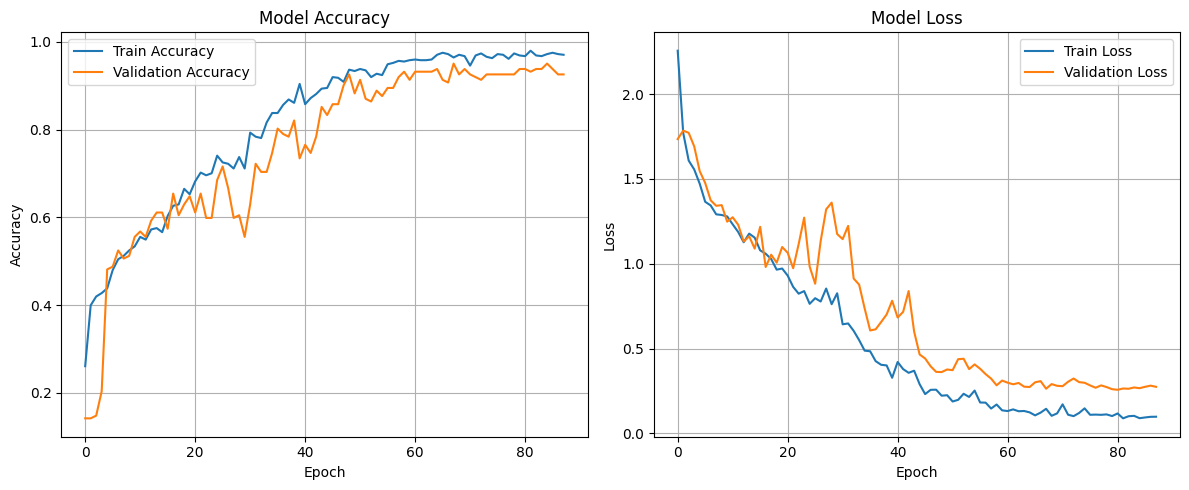

In [20]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt


def augment_data(X, noise_level=0.005):
    """
    Adds random Gaussian noise to the keypoint data to create augmented samples.
    This helps the model generalize better to slight variations in pose.
    """
    X_aug = X.copy()
    noise = np.random.normal(0, noise_level, X_aug.shape)
    return X_aug + noise


def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def train_model():
    """Trains an improved model on the extracted features with data augmentation."""
    print("\nStarting improved model training...")
    df = pd.read_csv('pose_features.csv')

    sequence_length = 30
    features_cols = df.columns[:-2]
    label_col = 'label'
    video_col = 'video'

    sequence_data = []
    sequence_labels = []

    for vid, group in df.groupby(video_col):
        label = group[label_col].iloc[0]
        group = group.reset_index(drop=True)

        for start in range(0, len(group) - sequence_length + 1, sequence_length):
            seq = group.loc[start:start + sequence_length - 1, features_cols].values
            sequence_data.append(seq)
            sequence_labels.append(label)

    X = np.array(sequence_data)
    y = np.array(sequence_labels)

    # --- Data Augmentation ---
    print(f"Original samples: {len(X)}")
    X_augmented = augment_data(X)
    X_combined = np.concatenate((X, X_augmented), axis=0)
    y_combined = np.concatenate((y, y), axis=0)
    print(f"Total samples after augmentation: {len(X_combined)}")

    le = LabelEncoder()
    y_encoded = le.fit_transform(y_combined)
    num_classes = len(le.classes_)
    y_cat = to_categorical(y_encoded, num_classes=num_classes)

    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

    # --- Deeper & Regularized Model Architecture ---
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(sequence_length, X.shape[2])),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.5),

        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # --- Optimizer with Weight Decay ---
    optimizer = AdamW(learning_rate=0.001, weight_decay=0.004)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    # --- Refined Callbacks ---
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001)

    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )

    model.save('cricket_shot_lstm_model.h5')
    print("Model saved as cricket_shot_lstm_model.h5")

    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(le, f)
    print("Label encoder saved as label_encoder.pkl")

    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Final Test accuracy: {accuracy:.4f}')

    # Plot training graphs
    plot_training_history(history)


if __name__ == "__main__":
    train_model()
